In [134]:
import time
import pickle
import numpy as np
from scipy import signal
from scipy import fftpack
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import f06_postpro as f06
import dat_tools as dat
import utils
import rfp
import oma
import mac

### Funciones de transferencia nodales por simulación

In [135]:
connect_dict_subassembly_fewer = {
    '1': ['11', '14'],
    '11': ['14', '15'],
    '18': ['14', '15'],
    '23': ['11', '14', '15', '18']
}

connect_dict_filename = 'connect_dict_subassembly_fewer.pickle'
with open(connect_dict_filename, 'wb') as handle:
    pickle.dump(connect_dict_subassembly_fewer, handle)

In [136]:
# Diccionario de conexiones nodales
connect_dict_filename = 'connect_dict_subassembly_fewer.pickle'
with open(connect_dict_filename, 'rb') as handle:
    connect_dict = pickle.load(handle)

In [137]:
f06_sinsweep_filname = 'C:\RUNRUN\sate_subassembly_sinex_fewer.f06'
f06_modal_filname = r'C:\RUNRUN\modal_femap\sate_subassemblies_modalhm-000.f06'
dat_sinsweep_filname = 'C:\RUNRUN\sate_subassembly_sinex_fewer.dat'
freq, accel, nodes = f06.read_nodes_accel(f06_sinsweep_filname)
Xi = dat.read_damping(dat_sinsweep_filname)
coords = dat.read_node_coords(dat_sinsweep_filname, nodes)
mode_freqs_all, modes_theo_all = f06.read_modeshapes(f06_modal_filname, nodes)

In [138]:
# Transfer matrix
input_node = 1
input_node_str = str(input_node)

TF_dict = accel.copy()
# Delete input node
if input_node_str in TF_dict: del TF_dict[input_node_str]

total_nodes = len(TF_dict.keys())
dof_per_node = 3
total_dofs = total_nodes * dof_per_node
TF = np.zeros((len(freq), total_dofs), dtype=complex)
node_order = dict()
node_order['1'] = 0 # nodo origen
dof_order = dict()
col = 0
for node_str in TF_dict.keys():
    dof_order[node_str] = col
    node_order[node_str] = (col+3)//3 # dejo lugar para nodo del origen
    TF[:,col:col+3] = TF_dict[node_str]
    col += 3

In [139]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:total_dofs]

In [140]:
dof_order

{'11': 0, '14': 3, '15': 6, '18': 9, '23': 12}

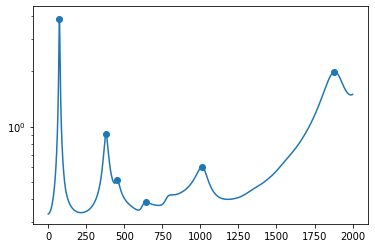

In [141]:
avg_TF = np.mean(np.abs(TF), axis=1)
mode_ind_TF = np.array([m for m in signal.argrelmax(np.abs(avg_TF), order=20)]).flatten()
plt.semilogy(freq, np.abs(avg_TF))
plt.scatter(freq[mode_ind_TF], np.abs(avg_TF[mode_ind_TF]))

In [142]:
freq_analysis_lim = 500

mask = np.unique([np.argmin(np.abs(mode_freqs_all - freq[mode_idx])) for mode_idx in mode_ind_TF])
f_theo = mode_freqs_all[mask]
modes_theo = modes_theo_all[mask,3:].T

total_modes = len(f_theo)
xi_theo = Xi*np.ones(total_modes)
mode_nums = np.arange(total_modes)+1

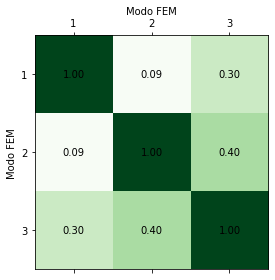

In [143]:
MAC_theo = mac.get_MAC_matrix(modes_theo, modes_theo)
mac.plot_MAC(MAC_theo, 'Greens', 'k', title_str=None, labels=['Modo FEM', 'Modo FEM'])
plt.savefig('AutoMAC_theo_lessTime.pdf', bbox_inches='tight')

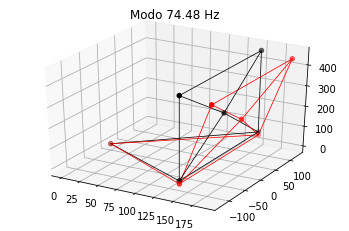

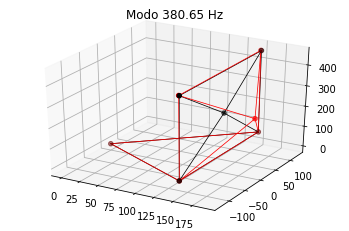

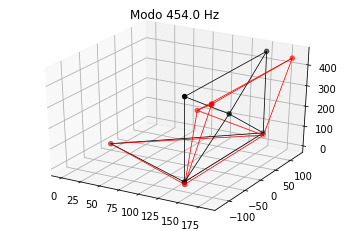

In [144]:
for mode_idx in range(3):
    mode_shape = modes_theo[:, mode_idx]
    mode_name = 'Modo {} Hz'.format(np.round(freq[mode_ind_TF[mode_idx]], 2))
    utils.plot_3d_mode(node_order, coords, connect_dict, mode_shape, mode_name, magnif=40)

### Ruido blanco en la base

In [145]:
g_rms = 1
t_end = 60
f_s = 1200
delta_t = 1/f_s
t = np.linspace(0, t_end, int(t_end/delta_t))
Ug_time = g_rms * np.random.normal(size=len(t))

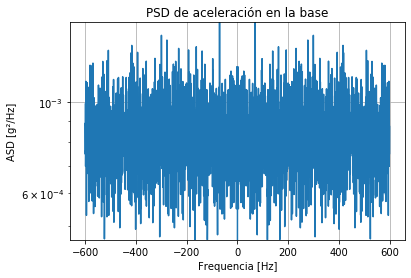

In [146]:
# PSD de aceleraciones en la base
nperseg = 4096
Ug_psd_freq, Ug_psd = signal.welch(Ug_time, 
                      fs=f_s, # sample rate
                      window='hamming', # apply a Hanning window before taking the DFT
                      nperseg=nperseg, # compute periodograms of 256-long segments of x
                      detrend='constant', # detrend x by subtracting the mean)
                      return_onesided=False)

plt.figure()
plt.semilogy(Ug_psd_freq, Ug_psd)
plt.title('PSD de aceleración en la base')
plt.ylim([np.min(Ug_psd[1:]), np.max(Ug_psd[1:])])
plt.xlabel('Frequencia [Hz]')
plt.ylabel('ASD [g²/Hz]')
plt.grid()
plt.show()

In [147]:
# Transformada de Fourier de aceleraciones en la base
Ug_fft = np.fft.fft(Ug_time) * delta_t
Ug_fft_freq = np.fft.fftfreq(len(t), d=delta_t)

In [148]:
# Interpolacion de transferencias las frecuencias de excitación
TF_inter = np.zeros((len(Ug_fft_freq), TF.shape[1]), dtype=complex)
for dof in range(TF.shape[1]):
    TF_inter[:,dof] = np.interp(Ug_fft_freq, freq, TF[:,dof])

In [149]:
# Espectros de respuesta
ddotY_fft = (TF_inter.T*Ug_fft).T

In [150]:
# Respuestas temporales
ddotY_time = fftpack.ifft(ddotY_fft, axis=0)

## GRFP

In [151]:
S_xf = np.zeros((nperseg, total_dofs), dtype=complex)
for dof in range(total_dofs):
        f_Sxf, S_xf[:, dof] = signal.csd(ddotY_time[:, dof], Ug_time,
                                               fs=f_s,
                                               window='hanning',
                                               nperseg=nperseg,
                                               detrend='constant',
                                               axis=0,
                                               return_onesided=False)

In [152]:
f_H = f_Sxf[:len(f_Sxf)//2]
H1 = S_xf[:len(f_H),:]/Ug_psd[:len(f_H), np.newaxis]

In [183]:
freq_range = [20, 500]
idxes = np.where((f_H >= freq_range[0]) & (f_H <=freq_range[1]))[0]

In [196]:
n_modes = 5
m = 2*n_modes-1
n = 2*n_modes
denom, denom_coeff = rfp.grfp_denominator(H1[idxes, :], 2*np.pi*f_H[idxes],n,m)

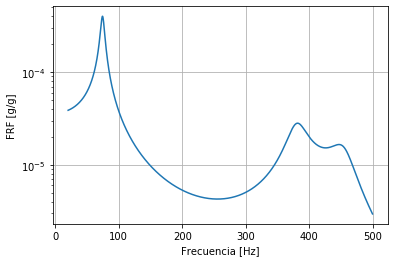

In [197]:
plt.semilogy(f_H[idxes], np.abs(1/denom))
plt.ylabel('FRF [g/g]')
plt.xlabel('Frecuencia [Hz]')
plt.grid()
plt.savefig('GRFP_denominator_lessTime.pdf', bbox_inches='tight')
plt.show()

In [198]:
polis = np.roots(denom_coeff)*np.max(2*np.pi*f_H[idxes])
print('f = {}'.format(np.round(np.abs(polis)/2/np.pi, 1)))
print('xi = {}'.format(np.round(-np.real(polis)/np.abs(polis), 3)))

f = [542.8 454.8 380.6 542.8 454.8 380.6 105.   74.5  74.5]
xi = [-0.17 -0.04 -0.04 -0.17 -0.04 -0.04 -1.   -0.04 -0.04]


In [157]:
[f_grfp, xi_grfp, modal_mag_n, modal_ang_n], alpha1 = rfp.grfp_parameters(H1[idxes,:], 2*np.pi*f_H[idxes], denom, denom_coeff, m)

In [158]:
print('Frecuencias modales:')
min_ind = np.min([len(vec) for vec in [mode_nums, f_theo, f_grfp]])
data = np.vstack((mode_nums[:min_ind], f_theo[:min_ind], f_grfp[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

Frecuencias modales:


Modo,Teoría [Hz],GRFP [Hz]
1,74.48,74.51
2,380.65,380.72
3,454.64,454.53


In [159]:
print('Amortiguamientos modales:')
min_ind = np.min([len(vec) for vec in [mode_nums, xi_theo, xi_grfp]])
data = np.vstack((mode_nums[:min_ind], xi_theo[:min_ind], xi_grfp[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

Amortiguamientos modales:


Modo,Teoría [Hz],GRFP [Hz]
1,0.04,-0.04
2,0.04,-0.04
3,0.04,-0.04


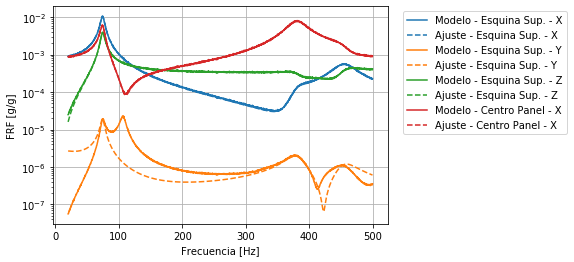

In [160]:
DOFS = np.array([9, 10, 11, 12])
names = ['Esquina Sup. - X', 'Esquina Sup. - Y', 'Esquina Sup. - Z', 'Centro Panel - X']
for idx in range(len(DOFS)):
    plt.semilogy(f_H[idxes], np.abs(H1[idxes[:, np.newaxis], DOFS[idx]]), color=colors[idx], label='Modelo - {}'.format(names[idx]))
    plt.semilogy(f_H[idxes], np.abs(alpha1[:, DOFS[idx]]), '--', color=colors[idx], label='Ajuste - {}'.format(names[idx]))
plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1))
plt.ylabel('FRF [g/g]')
plt.xlabel('Frecuencia [Hz]')
plt.grid()
plt.savefig('GRFP_fit_lessTime.pdf', bbox_inches='tight')
plt.show()

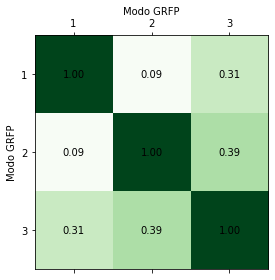

In [179]:
modes_grfp = (modal_mag_n*np.exp(1j*modal_ang_n)).T
MAC_grfp = mac.get_MAC_matrix(modes_grfp, modes_grfp)
mac.plot_MAC(MAC_grfp, 'Greens', 'k', title_str=None, labels=['Modo GRFP', 'Modo GRFP'])
plt.savefig('AutoMAC_GRFP_lessTime.pdf', bbox_inches='tight')

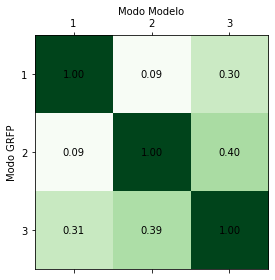

In [180]:
MAC_grfp = mac.get_MAC_matrix(modes_grfp, modes_theo)
mac.plot_MAC(MAC_grfp, 'Greens', 'k', title_str=None, labels=['Modo GRFP', 'Modo Modelo'])
plt.savefig('MAC_GRFPvsModelo_lessTime.pdf', bbox_inches='tight')

### FDD

In [163]:
S_xx = np.zeros((nperseg, total_dofs, total_dofs), dtype=complex)

start = time.time()
for dof1 in range(total_dofs):
    for dof2 in range(total_dofs):
        f_S, S_xx[:, dof1, dof2] = signal.csd(ddotY_time[:, dof1], ddotY_time[:, dof2],
                                                               fs=f_s,
                                                               window='hanning',
                                                               nperseg=nperseg,
                                                               detrend='constant',
                                                               axis=0,
                                                               return_onesided=False)
end = time.time()
print('Tiempo de calculo de S_xx: {}s'.format(round(end - start,2)))

Tiempo de calculo de S_xx: 3.3s


In [164]:
# Extraigo frecuencias y formas de modo por SVD
u_fdd, s_fdd, vh_fdd = np.linalg.svd(S_xx)

freq_fdd = f_S[:len(f_S)//2]
freq_range = [0, 500]
idxes = np.where(freq_fdd <= freq_range[1])[0]
# Maximos del primer valor singular
mode_ind_fdd = np.array([m for m in signal.argrelmax(s_fdd[idxes, 0], order=300)]).flatten()
mode_ind_fdd2 = np.array([m for m in signal.argrelmax(s_fdd[idxes, 1], order=80)]).flatten()

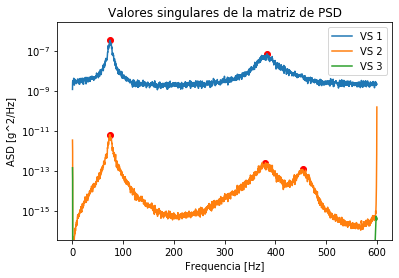

In [165]:
plt.semilogy(freq_fdd, s_fdd[:len(freq_fdd), :3])
plt.ylim([np.min(s_fdd[10:len(freq_fdd), 1]), None])
plt.scatter(freq_fdd[mode_ind_fdd],
            abs(s_fdd[mode_ind_fdd, 0]),
            color='r')
plt.scatter(freq_fdd[mode_ind_fdd2],
            abs(s_fdd[mode_ind_fdd2, 1]),
            color='r')
plt.title('Valores singulares de la matriz de PSD')
plt.ylabel('ASD [g^2/Hz]')
plt.xlabel('Frequencia [Hz]')
lgnd  = ['VS {}'.format(col+1) for col in range(3)]
plt.legend(lgnd, loc='upper right')
plt.show()

In [166]:
f_fdd = np.concatenate((freq_fdd[mode_ind_fdd], freq_fdd[mode_ind_fdd2][2, np.newaxis]))
fdd_total_modes = len(f_fdd)-1
min_ind = np.min([len(vec) for vec in [mode_nums, f_theo, f_grfp, f_fdd]])
data = np.vstack((mode_nums[:min_ind], f_theo[:min_ind], f_grfp[:min_ind], f_fdd[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]', 'FDD [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

Modo,Teoría [Hz],GRFP [Hz],FDD [Hz]
1,74.48,74.51,74.12
2,380.65,380.72,382.91
3,454.64,454.53,453.52


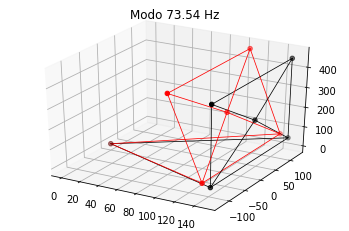

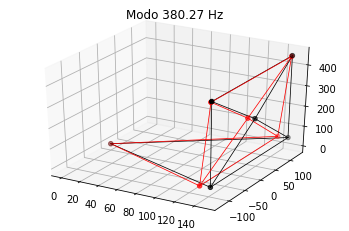

In [167]:
for mode_idx in range(fdd_total_modes):
    mode_shape = u_fdd[mode_ind_fdd2[mode_idx], :, 0]
    mode_name = 'Modo {} Hz'.format(np.round(freq_fdd[mode_ind_fdd2[mode_idx]], 2))
    utils.plot_3d_mode(node_order, coords, connect_dict, mode_shape, mode_name, magnif=100)

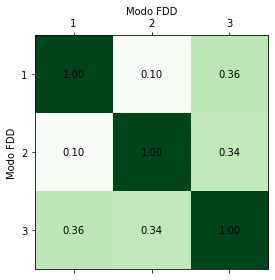

In [168]:
# Agrego 3er modo usando 2 vector singular
modes_fdd = u_fdd[mode_ind_fdd[:fdd_total_modes],:,0].T
modes_fdd2 = np.concatenate((modes_fdd, u_fdd[mode_ind_fdd2[2],:,1].T[:,np.newaxis]), axis=1)
MAC_fdd2 = mac.get_MAC_matrix(modes_fdd2, modes_fdd2)
mac.plot_MAC(MAC_fdd2, 'Greens', 'k', title_str=None, labels=['Modo FDD', 'Modo FDD'])
plt.savefig('AutoMAC_FDD_lessTime.pdf', bbox_inches='tight')

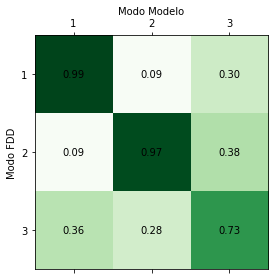

In [169]:
MAC_fdd2 = mac.get_MAC_matrix(modes_fdd2, modes_theo)
mac.plot_MAC(MAC_fdd2, 'Greens', 'k', title_str=None, labels=['Modo FDD', 'Modo Modelo'])
plt.savefig('MAC_FDDvsModelo_lessTime.pdf', bbox_inches='tight')

### EFDD

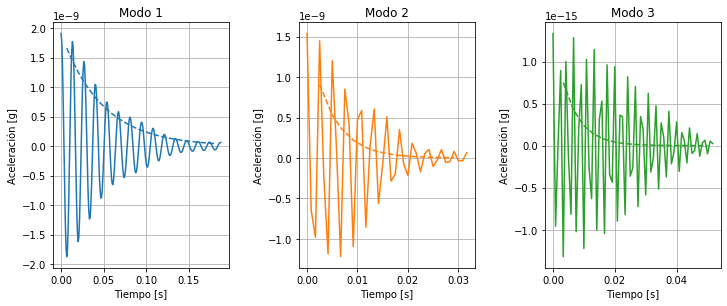

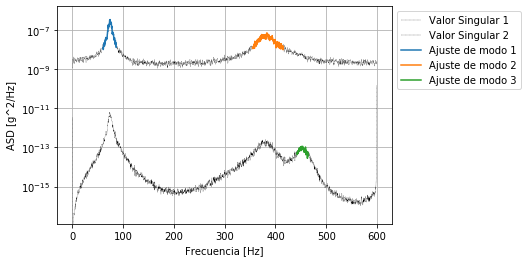

In [170]:
sv_num = 0
mac_th = np.array([0.9, 0.9, 0.9])
sdof_psd = np.zeros((f_S.size, fdd_total_modes+1), dtype=complex)
sdof_acf = np.zeros((f_S.size, fdd_total_modes+1), dtype=complex)
t_sdof_acf = np.linspace(0, sdof_psd.shape[0]/f_s, sdof_psd.shape[0])
f_efdd = np.zeros(fdd_total_modes+1)
xi_efdd = np.zeros(fdd_total_modes+1)
R2 = np.zeros(fdd_total_modes+1)

fig_decay, ax_decay = plt.subplots(1, fdd_total_modes+1, figsize=(10,4))
fig_decay.tight_layout(h_pad=10, w_pad=0.12)
fig_decay.subplots_adjust(wspace = 0.4, hspace=0.4)
fig_psd, ax_psd = plt.subplots()
# fig_decay.suptitle('Ajuste de los decaimientos como logaritmicos', y=1.1)
ax_psd.semilogy(f_S[:len(f_S)//2], s_fdd[:len(f_S)//2, 0], '--', color='k', linewidth=0.25, label='Valor Singular 1')
ax_psd.semilogy(f_S[:len(f_S)//2], s_fdd[:len(f_S)//2, 1], '--', color='k', linewidth=0.25, label='Valor Singular 2')

[ax_decay.flat[i].grid(True, markevery=1) for i in range(len(ax_decay.flat))]

for mode in range(fdd_total_modes):
    peak_idx = mode_ind_fdd[mode]
    idx_low, idx_high = oma.get_efdd_segment(u_fdd, peak_idx, mac_th[mode], sv_num)
    sdof_psd[idx_low:idx_high, mode] = s_fdd[idx_low:idx_high, sv_num]
    sdof_acf[:, mode] = fftpack.ifft(sdof_psd[:, mode])
    # Find index where amplitude stops falling
    decay_end = np.where(np.diff(np.abs(sdof_acf[:, mode]))>0)[0][0] 
    decay = np.real(sdof_acf[:decay_end, mode])
    
    xi_efdd[mode], R2[mode], A, b, c, m = oma.get_damp_from_decay(decay)
    f_efdd_damped = oma.get_freq_from_signal(t_sdof_acf, sdof_acf[:, mode])
    f_efdd[mode] = f_efdd_damped / np.sqrt(1-xi_efdd[mode]**2)
    
    w_n_efdd = 2*np.pi*f_efdd[mode]
    peak_ind = np.array([m for m in signal.argrelmax(abs(decay), order=1)]).flatten()

    ax_psd.semilogy(f_S[idx_low:idx_high], s_fdd[idx_low:idx_high, sv_num], label='Ajuste de modo {}'.format(mode+1))

    ax_decay.flat[mode].plot(t_sdof_acf[:decay_end], decay, color=colors[mode])
    ax_decay.flat[mode].plot(t_sdof_acf[peak_ind],
                             decay[0]*np.exp(-xi_efdd[mode]*w_n_efdd*t_sdof_acf[peak_ind]),
                             color=colors[mode], linestyle='--')
    ax_decay.flat[mode].set_xlabel('Tiempo [s]')
    ax_decay.flat[mode].set_ylabel('Aceleración [g]')
    ax_decay.flat[mode].set_title('Modo {}'.format(mode+1))


mode = 2
sv_num = 1
# mac_th = 0.95
peak_idx = mode_ind_fdd2[mode]
idx_low, idx_high = oma.get_efdd_segment(u_fdd, peak_idx, mac_th[mode], sv_num)
sdof_psd[idx_low:idx_high, mode] = s_fdd[idx_low:idx_high, sv_num]

sdof_acf[:, mode] = fftpack.ifft(sdof_psd[:, mode])
# Find index where amplitude stops falling
decay_end = np.where(np.diff(np.abs(sdof_acf[:, mode]))>0)[0][0] 
decay = np.real(sdof_acf[:decay_end, mode])

xi_efdd[mode], R2[mode], A, b, c, m = oma.get_damp_from_decay(decay)
f_efdd_damped = oma.get_freq_from_signal(t_sdof_acf, sdof_acf[:, mode])
f_efdd[mode] = f_efdd_damped / np.sqrt(1-xi_efdd[mode]**2)

w_n_efdd = 2*np.pi*f_efdd[mode]
peak_ind = np.array([m for m in signal.argrelmax(abs(decay), order=1)]).flatten()

ax_psd.semilogy(f_S[idx_low:idx_high], s_fdd[idx_low:idx_high, sv_num], label='Ajuste de modo {}'.format(mode+1))
ax_psd.set_ylim([np.max(np.abs(s_fdd[:, 3])), None])
ax_psd.set_xlabel('Frecuencia [Hz]')
ax_psd.set_ylabel('ASD [g^2/Hz]')
ax_psd.grid()
ax_psd.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

ax_decay.flat[mode].plot(t_sdof_acf[:decay_end], decay, color=colors[mode])
ax_decay.flat[mode].plot(t_sdof_acf[peak_ind],
                         decay[0]*np.exp(-xi_efdd[mode]*w_n_efdd*t_sdof_acf[peak_ind]),
                         color=colors[mode], linestyle='--')
ax_decay.flat[mode].set_xlabel('Tiempo [s]')
ax_decay.flat[mode].set_ylabel('Aceleración [g]')
ax_decay.flat[mode].set_title('Modo {}'.format(mode+1))


fig_psd.savefig('EFDD_peaks_lessTime.pdf', bbox_inches='tight')
fig_decay.savefig('EFDD_lessTime.pdf', bbox_inches='tight')

### CFDD

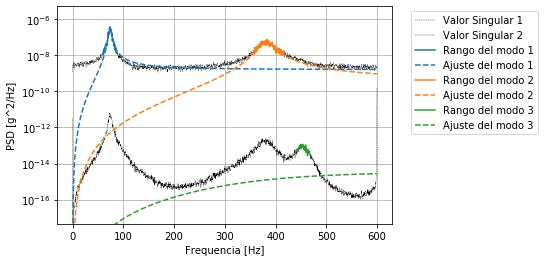

In [171]:
sv_num = 0
mac_th = np.array([0.9, 0.9, 0.9])
f_cfdd = np.zeros(fdd_total_modes+1)
xi_cfdd = np.zeros(fdd_total_modes+1)

freq_hat = np.linspace(0, f_S[len(f_S)//2-1], 6000)
psd_hat = np.zeros((freq_hat.size, fdd_total_modes+1))

plt.semilogy(f_S[:len(f_S)//2], s_fdd[:len(f_S)//2, 0], '--', color='k', linewidth=0.35, label='Valor Singular 1')
plt.semilogy(f_S[:len(f_S)//2], s_fdd[:len(f_S)//2, 1], '--', color='k', linewidth=0.35, label='Valor Singular 2')

for mode in range(fdd_total_modes):
    peak_idx = mode_ind_fdd[mode]
    efdd_idxes = oma.get_efdd_segment(u_fdd, peak_idx, mac_th[mode], sv_num)
    f_cfdd[mode], xi_cfdd[mode], psd_hat[:, mode] = oma.curve_fit_psd_peak(f_S[:len(f_S)//2], s_fdd[:len(f_S)//2, sv_num], efdd_idxes, freq_hat)
    
    plt.semilogy(f_S[efdd_idxes[0]:efdd_idxes[1]],
                 abs(s_fdd[efdd_idxes[0]:efdd_idxes[1], sv_num]),
                 color=colors[mode],
                 label='Rango del modo {}'.format(mode+1))
    plt.semilogy(freq_hat[:freq_hat.size],
                 abs(psd_hat[:freq_hat.size, mode]),
                 color=colors[mode],
                 linestyle='--',
                 label='Ajuste del modo {}'.format(mode+1))

mode = 2
sv_num = 1
peak_idx = mode_ind_fdd2[mode]
efdd_idxes = oma.get_efdd_segment(u_fdd, peak_idx, mac_th[mode], sv_num)
f_cfdd[mode], xi_cfdd[mode], psd_hat[:, mode] = oma.curve_fit_psd_peak(f_S[:len(f_S)//2], s_fdd[:len(f_S)//2, sv_num], efdd_idxes, freq_hat)

plt.semilogy(f_S[efdd_idxes[0]:efdd_idxes[1]],
             abs(s_fdd[efdd_idxes[0]:efdd_idxes[1], sv_num]),
             color=colors[mode],
             label='Rango del modo {}'.format(mode+1))
plt.semilogy(freq_hat[:freq_hat.size],
             abs(psd_hat[:freq_hat.size, mode]),
             color=colors[mode],
             linestyle='--',
             label='Ajuste del modo {}'.format(mode+1))
# plt.title('Ajuste por CFDD de picos de 1er valor singular')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1))
plt.xlabel('Frequencia [Hz]')
plt.ylabel('PSD [g^2/Hz]')
plt.ylim([np.max(np.abs(s_fdd[:, 4])), None])
plt.grid()
plt.savefig('CFDD_lessTime.pdf', bbox_inches='tight')
plt.show()

In [172]:
print('Frecuencias modales:')
min_ind = np.min([len(vec) for vec in [mode_nums, f_theo, f_grfp, f_fdd, f_efdd, f_cfdd]])
data = np.vstack((mode_nums[:min_ind], f_theo[:min_ind], f_grfp[:min_ind], f_fdd[:min_ind], f_efdd[:min_ind], f_cfdd[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]', 'FDD [Hz]', 'EFDD [Hz]', 'CFDD [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2, save_title='tab_compare_freq_lessTime')

Frecuencias modales:


Modo,Teoría [Hz],GRFP [Hz],FDD [Hz],EFDD [Hz],CFDD [Hz]
1,74.48,74.51,74.12,73.84,73.50
2,380.65,380.72,382.91,382.50,380.70
3,454.64,454.53,453.52,453.61,447.43


In [173]:
min_ind = np.min([len(vec) for vec in [mode_nums, xi_theo, xi_grfp, xi_efdd, xi_cfdd]])
data = np.vstack((mode_nums[:min_ind], xi_theo[:min_ind], xi_grfp[:min_ind], xi_efdd[:min_ind], xi_cfdd[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]', 'EFDD [Hz]', 'CFDD [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=3, save_title='tab_compare_damp_lessTime')

Modo,Teoría [Hz],GRFP [Hz],EFDD [Hz],CFDD [Hz]
1,0.040,-0.039,0.045,0.033
2,0.040,-0.040,0.088,0.037
3,0.040,-0.039,0.060,0.707


In [177]:
f_H

array([0.00000000e+00, 2.92968750e-01, 5.85937500e-01, ...,
       5.99121094e+02, 5.99414062e+02, 5.99707031e+02])

In [178]:
f_S

array([ 0.        ,  0.29296875,  0.5859375 , ..., -0.87890625,
       -0.5859375 , -0.29296875])